In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.efficientnet import preprocess_input
import random
import cv2
from sklearn.metrics import accuracy_score
import time


In [ ]:
!unzip ProductRecoginition.zip

In [ ]:

random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

ROOT = r'/content/Product Recoginition/Training Data'
ROOTv = r'/content/Product Recoginition/Validation Data'

def read_image(index,root):
    path = os.path.join(root, index[0], index[1])
    image = cv2.imread(path)

    if image is None:
        print(f"Error: Unable to read image from path: {path}")
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image






In [ ]:

def split_dataset(directory):
    folders = os.listdir(directory)
    num_train = int(len(folders))

    random.shuffle(folders)
    list= {}

    # Creating Train-list
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        list[folder] = num_files

    # Creating Test-list
    # for folder in folders[num_train:]:
    #     num_files = len(os.listdir(os.path.join(directory, folder)))
    #     test_list[folder] = num_files

    return list

train_list = split_dataset(ROOT)
test_list = split_dataset(ROOTv)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list)








Length of training list: 40
Length of testing list : 20

Test List: {'53': 6, '42': 6, '43': 6, '58': 6, '50': 6, '56': 6, '48': 6, '46': 6, '55': 6, '45': 6, '49': 6, '44': 6, '54': 6, '60': 6, '57': 6, '51': 6, '52': 6, '59': 6, '47': 6, '41': 6}


In [ ]:

def create_triplets(directory, folder_list, max_files=10):
    triplets = []
    folders = list(folder_list.keys())

    for folder in folders:
        path = os.path.join(directory, folder)
        files = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))][:max_files]
        num_files = len(files)

        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor_name = files[i]
                positive_name = files[j]

                # Check if the files exist before adding them to triplets
                if anchor_name in files and positive_name in files:
                    anchor = (folder, anchor_name)
                    positive = (folder, positive_name)

                    neg_folder = folder
                    while neg_folder == folder:
                        neg_folder = random.choice(folders)
                    neg_files = [f for f in os.listdir(os.path.join(directory, neg_folder)) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
                    neg_file = random.choice(neg_files)
                    negative = (neg_folder, neg_file)

                    triplets.append((anchor, positive, negative))

    random.shuffle(triplets)
    return triplets
train_triplet = create_triplets(ROOT, train_list)
test_triplet  = create_triplets(ROOTv, test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))


print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])


Number of training triplets: 1018
Number of testing triplets : 265

Examples of triplets:
(('35', 'web1.png'), ('35', 'web2.png'), ('37', 'web3.png'))
(('35', 'web5.png'), ('35', 'web2.png'), ('19', 'web1.png'))
(('15', 'web8.png'), ('15', 'web3.png'), ('25', 'web6.png'))
(('1', 'web9.png'), ('1', 'web8.png'), ('40', 'web4.png'))
(('8', 'web5.png'), ('8', 'web8.png'), ('34', 'web3.png'))


In [ ]:



def resize_image(img, target_shape=(128, 128)):
    # Resize the image to the target shape
    return cv2.resize(img, target_shape)



In [ ]:
def get_batch(triplet_list, batch_size=20, preprocess=True, target_shape=(128, 128),ROOT=ROOT):
    print("Results are")
    batch_steps = len(triplet_list)//batch_size

    for i in range(batch_steps+1):
        anchor = []
        positive = []
        negative = []

        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]

            # Check if the files exist before adding them to triplets
            anchor_img = read_image(a,ROOT)
            positive_img = read_image(p,ROOT)
            negative_img = read_image(n,ROOT)

            # Skip if any of the images is None
            if anchor_img is None or positive_img is None or negative_img is None:
                print(f"Skipping batch {i} due to missing images.")
                j += 1
                continue

            anchor_img = resize_image(anchor_img, target_shape)
            positive_img = resize_image(positive_img, target_shape)
            negative_img = resize_image(negative_img, target_shape)

            anchor.append(anchor_img)
            positive.append(positive_img)
            negative.append(negative_img)
            j += 1

        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)

        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)

        yield ([anchor, positive, negative])




Results are


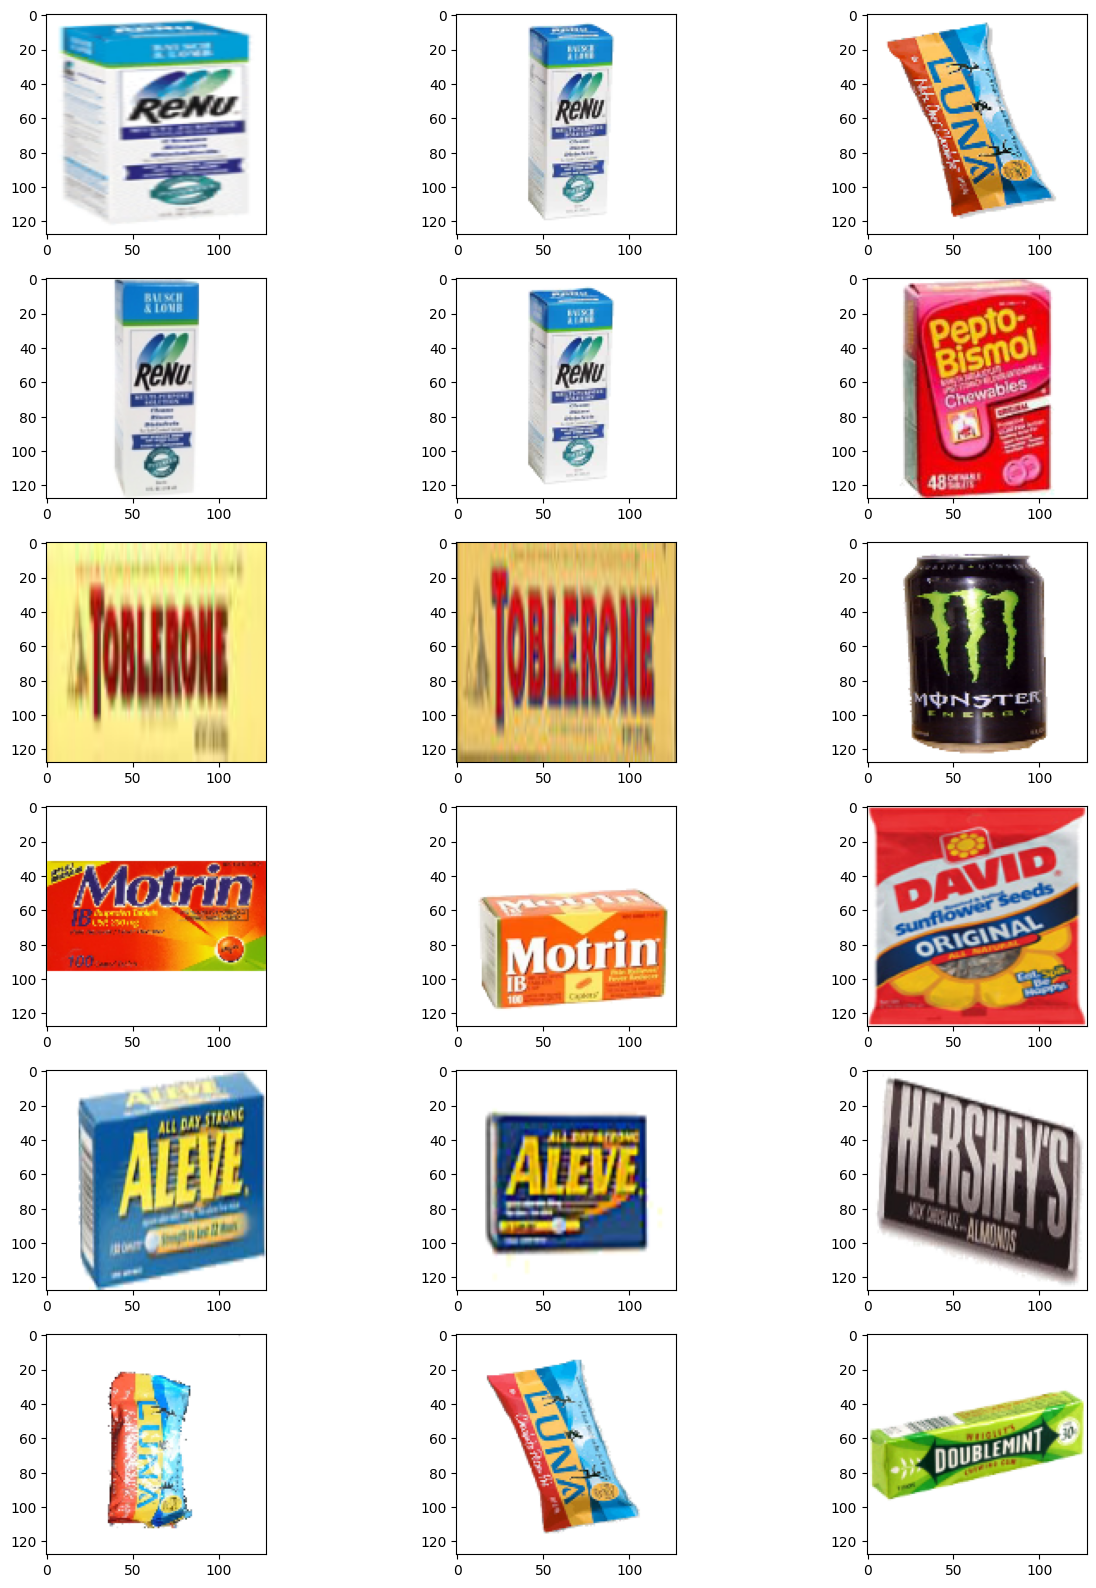

In [ ]:

num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break



In [ ]:

from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report





In [ ]:


def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )

    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model



In [ ]:


class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)

    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")

    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)

    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )

    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network(input_shape=(128, 128, 3))
siamese_network.summary()






Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Anchor_Input (InputLayer)   [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Positive_Input (InputLayer  [(None, 128, 128, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 Negative_Input (InputLayer  [(None, 128, 128, 3)]        0         []                            
 )                                                                                                
                                                                                    

In [ ]:

class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()

        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]




In [ ]:


siamese_model = SiameseModel(siamese_network)
optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)



In [ ]:


def test_on_triplets(batch_size = 20,ROOT=ROOTv,test=test_triplet):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size,ROOT=ROOTv):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])

    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)

    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)




In [24]:

save_all = False
epochs = 1
batch_size = 20

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()

    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")

    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]

    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy

siamese_model.save_weights("siamese_model-final")
siamese_model.save("siamese_model-final")



Results are

EPOCH: 1 	 (Epoch done in 378 sec)
Loss on train    = 0.28031
Results are
1/1 [==============================] - 2s 2s/step
Accuracy on test = 0.78800
Results are

EPOCH: 2 	 (Epoch done in 354 sec)
Loss on train    = 0.20013
Results are
1/1 [==============================] - 3s 3s/step
Accuracy on test = 0.82000
Results are

EPOCH: 3 	 (Epoch done in 351 sec)
Loss on train    = 0.18278
Results are
1/1 [==============================] - 3s 3s/step
Accuracy on test = 0.79200
Results are

EPOCH: 4 	 (Epoch done in 332 sec)
Loss on train    = 0.15196
Results are
1/1 [==============================] - 2s 2s/step
Accuracy on test = 0.84000
Results are

EPOCH: 5 	 (Epoch done in 337 sec)
Loss on train    = 0.13729
Results are
1/1 [==============================] - 2s 2s/step
Accuracy on test = 0.78000
Results are

EPOCH: 6 	 (Epoch done in 334 sec)
Loss on train    = 0.12899
Results are
1/1 [==============================] - 2s 2s/step
Accuracy on test = 0.83200
Results are

EPO

In [26]:



def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()


# Saving the model after all epochs run

encoder.save("encoder")


Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_14 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 lambda_2 (Lambda)           (None, 256)               0         
                                                      

In [27]:

def classify_images(list1, list2, threshold=0.9):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(list1)
    tensor2 = encoder.predict(list2)

    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction




Results are
8/8 [==============================] - 17s 2s/step

Accuracy of model: 0.682



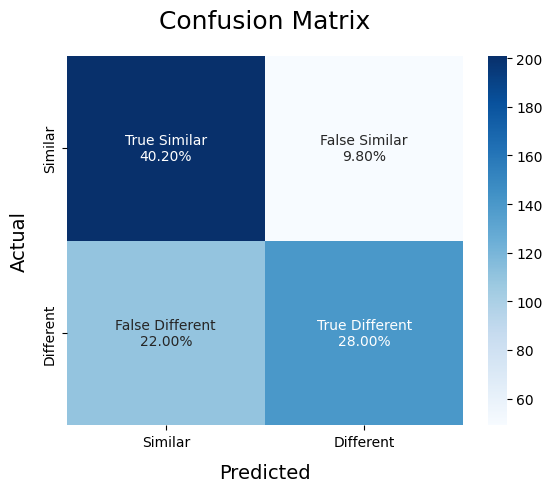

In [29]:


def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)

    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=256, ROOT=ROOTv):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)

In [ ]:
!unzip test_images.zip

Archive:  test_images.zip
   creating: test_images/
  inflating: test_images/web2.png    
  inflating: test_images/web3.png    
  inflating: test_images/web4.png    
  inflating: test_images/web5.png    
  inflating: test_images/web6.png    


In [ ]:
!unzip Newfolder.zip

unzip:  cannot find or open /content/Newfolder.zip, /content/Newfolder.zip.zip or /content/Newfolder.zip.ZIP.


In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import preprocess_input


def most_similar_img(encoder, test_image, training_images):
    test_encoding = encode_image(encoder, test_image)

    # Compare the test image encoding with each training image encoding
    similar = [np.sum(np.square(test_encoding - encode_image(encoder, train_image))) for train_image in
                    training_images]

    # Find the index of the most similar training image
    most_similar_index = np.argmin(similar)
    return most_similar_index

def read_image(file_path, target_size=(128, 128)):
    image = cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    return image

def encode_image(encoder, image):
    image = np.expand_dims(image, axis=0)
    encoded_image = encoder.predict(preprocess_input(image))
    return encoded_image

def main():
    # Load the Siamese model
    siamese_model = load_model("siamese_model-final", compile=False)
    # Load the encoder
    encoder = load_model("encoder", compile=False)
  ##case1##
    # Load training images for the first case
    training_img_dir = "/content/Product Recoginition/Training Data"
    training_images = [read_image(os.path.join(training_img_dir, str(i), f"web1.png")) for i in range(1, 41)]

    # Path to the directory containing test images for the first case
    testdir = "/content/Newfolder"
    # Case 1: Testing on images of different products
    for unseen_test_images in os.listdir(testdir):
        unseen_test_image_path = os.path.join(testdir, unseen_test_images)
        unseen_test_image = read_image(unseen_test_image_path)

        unseen_most_similar = most_similar_img(encoder, unseen_test_image, training_images)
        print(f"Unseen Test Image: {unseen_test_images}, Most Similar Product: {unseen_most_similar + 1}")

if __name__ == "__main__":
    main()


1/1 [==============================] - 0s 93ms/step
Unseen Test Image: 15.png, Most Similar Product: 15
1/1 [==============================] - 0s 97ms/step
Unseen Test Image: 40.png, Most Similar Product: 40
1/1 [==============================] - 0s 152ms/step
Unseen Test Image: 38.png, Most Similar Product: 38
1/1 [==============================] - 0s 87ms/step
Unseen Test Image: 32.png, Most Similar Product: 32
1/1 [==============================] - 0s 107ms/step
Unseen Test Image: 12.png, Most Similar Product: 30
1/1 [==============================] - 0s 144ms/step
Unseen Test Image: 10.png, Most Similar Product: 26


In [31]:
!unzip /content/OneShotRecognition.zip

Archive:  /content/OneShotRecognition.zip
   creating: One Shot Recognition/
  inflating: One Shot Recognition/anchor.png  
  inflating: One Shot Recognition/anchor2.png  
  inflating: One Shot Recognition/CocaCola_US.png  
  inflating: One Shot Recognition/Duo_US.png  
  inflating: One Shot Recognition/Fury_US.png  
  inflating: One Shot Recognition/Monster_US.png  
  inflating: One Shot Recognition/Pepsi_US.png  
  inflating: One Shot Recognition/Redbull_US.png  
  inflating: One Shot Recognition/Schweppes_US.png  
  inflating: One Shot Recognition/Spero_EGYPT.png  
 extracting: One Shot Recognition/Sprite_US.png  


In [40]:
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import cv2
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
from tensorflow.keras.applications.inception_v3 import preprocess_input

  ##case2##

test_folder_path = "/content/One Shot Recognition"
ancor_path = "/content/One Shot Recognition/anchor2.png"  #ancor path
encoder_model = load_model("/content/encoder")


def read_image(image_path):
  # image=cv2.imread(image_path)
    image = load_img(image_path, target_size=(128, 128))
    image = img_to_array(image)
    image = preprocess_input(image)
    return image

def compute_feature_vector(image, encoder_model):
    image = np.expand_dims(image, axis=0)
    embedding = encoder_model.predict(image)
    return embedding






reference_image = read_image(ancor_path)
ancor_vector = compute_feature_vector(reference_image, encoder_model)

test_images = [os.path.join(test_folder_path, f) for f in os.listdir(test_folder_path) if f.endswith(('.png', '.jpg', '.jpeg', '.gif'))]


test_embeddings = [compute_feature_vector(read_image(image_path), encoder_model) for image_path in test_images]



similarities = []
for test_vector, image_path in zip(test_embeddings, test_images):
    ancor_vector =ancor_vector.reshape(-1)
    test_vector=test_vector.reshape(-1)

    similarity = euclidean(ancor_vector, test_vector)
    similarities.append((image_path, similarity))


# Print similarities
print("\nMost similar images to the reference image:")
similar=10.0
imgpath=""
for image_path, similarity in similarities:

    if(similar>similarity and similarity!=0):
      similar=similarity
      imgpath=image_path

print(f"{imgpath}: {similar}")





1/1 [==============================] - 0s 170ms/step

Most similar images to the reference image:
/content/One Shot Recognition/anchor.png: 0.6940144896507263
